In [9]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

leer https://github.com/fonnesbeck/scipy2015_tutorial

desde ## Bayesian Computation en adelante


## Métodos de muestreo (_samplers_)

Existen varios métodos numéricos que pueden funcionar como _motores de inferencia_. La mayoría de ellos estan basados en la idea de que aún cuando no es posible obtener analíticamente la distribución _a posteriori_ suele ser posible tomar muestras de dicha distribución de forma tal de obtener una una descripción aproximada, pero confiable.


## Markov Chain Monte Carlo.  

[Markov Chain Monte Carlo](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) es el nombre de una familia de algoritmos que son extensamente usados en casi todas las ramas de la ciencia. El principal propósito de estos algoritmos es el de obtener muestras de una distribución de probabilidad que es difícil (o imposible) de tratar analíticamente. Esto se logra mediante la construcción de una cadena de Markov que tiene como distribución de equilibrio la distribución que nos interesa. Esto quiere decir que el método garantiza (bajo ciertas condiciones) que mientras más muestras tomemos más nos aproximemos a la distribución deseada. En este contexto una cadena es una secuencia de estados y las probabilidades de transición entre dichos estados. Una cadena de Markov es el caso especial de una cadena en donde la probabilidad de pasar al próximo estado depende solo del estado actual y no del camino al que se llegó al estado actual.

Un ejemplo clásico de una cadena de Markov es la llamada caminata del borracho. Para el caso unidimensional tenemos que a cada paso el borracho puede o bien moverse a la derecha o bien a la izquierda, con una cierta probabilidad. En este ejemplo se vé claramente que la probabilidad de pasar de un estado al otro no depende de los pasos previos del borracho si no solo de su posición actual.

Bien ahora que sabemos que es una cadena de Markov nos queda ver que es un _Monte Carlo_. El método es un Monte Carlo debido a que usa números aleatorios para obtener resultados. Monte Carlo es el nombre de un casino en Mónaco donde el tío de uno de los creadores del método solía apostar. La idea central de un méotodo de Monte Carlo es que es posible estudiar sistemas complicados muestreándolos en vez de estudiandolos directamente. Por ejemplo si querés saber las probabilidades de ganar en un juego de solitario una opción es tratar de obtener la respuesta de forma analítica (algo un poco complicado dada la naturaleza combinatoria del problema) La otra opción es simplemente jugar tantas partidas de solitario como se pueda y estimar la probabilidad de ganar en el solitario a partir de esas muestras. De hecho es exactamente este problema el que se planteó Stanislaw Ulam (circa 1940) mientras se recuperaba de una cirugía y jugaba al solitario. En esa época las computadoras empezaban a ser una realidad y este y otros investigadores rápidamente vieron el potencial de resolver infinidad de problemas mediante simulaciones simples. La simplicidad de la idea y el aumento incesante del poder de cálculo ha hecho que la aplicación y utilidad de los métodos de Monte Carlo no haya hecho otra cosa que aumentar con el paso de los años.

Dentro de la gran familiar de algoritmos de Markov Chain Monte Carlo el probablemente más usado sea el método de Metropolis-Hastings el cual discutiremos en la próxima sección.

### Metropolis-Hastings

El algortimo de [Metropolis–Hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) permite obtener muestras de cualquier distribución de probabilidad $P(x)$ siempre y cuando sea posible computar un valor proporcional a $P(x)$. Esto es muy útil, por que en muchos problemas incluida la estadística Bayesiana lo que suele ser difícil de computar es el factor de normalización (el denominador en el teorema de Bayes). Para distribuciones simples existen métodos más directos para muestrearlas, pero Metropolis-Hastings al igual que otros métodos MCMC se vuelven cada vez más útiles a medida que las dimensiones aumentan.


El algoritmo de Metropolis-Hastings consiste en los siguientes pasos

1. Elegir un estado inicial $x_i$ (al azar o haciendo uso de información disponible)
2. Elegir un nuevo estado $x_{i+1}$ muestreando a partir de una distribución conocida $Q(x_{i+1}|x_{i})$, o en otras palabras perturbando el estado $x_i$.
3. Computar la probabilidad de aceptar el nuevo estado según la siguiente regla: 

    $$A(x_{i+1} | x_i) = \min\left(1,\frac{P(x_{i+1})}{P(x_{i})}\frac{Q(x_{i} | x_{i+1})}{Q(x_{i+1} | x_{i})}\right)$$

4. Si la probabilidad computada en 3 es más grande que un valor tomado de una distribución uniforme sobre el intervalo [0, 1] aceptar el nuevo estado, caso contrario mantenerse en el estado actual.
5. Iterar desde 2 hasta _convergencia_

Un par de detalles para tener en cuenta

* Si el nuevo estado se propone usando una distribución simétrica, se obtiene:

    $$A(x_{i+1} | x_i) = \min\left(1,\frac{P(x_{i+1})}{P(x_{i})}\right)$$

* Los pasos 3 y 4 implican que siempre aceptamos un paso que nos mueve hacia una zona de mayor probabilidad. Estados menos probables son aceptados probabilísticamente mientrás más grande la diferencia de probabilidades más baja la probabilidad de aceptar el paso.
* Si un estado es aceptado se guarda el valor de ese estado y si es rechazado también, al finalizar tendremos una cadena con varios estados. Si todo _salió bien_ la frecuencia de cada estado en nuestra cadena será (aproximadamente) proporcional a la probabilidad de dicho estado según dicta la distribución de probabilidad que queríamos muestrear (y que no podíamos resolver analíticamente).

In [42]:
def metropolis(func, steps=10000):
    # seed the random number generator
    np.random.seed(1234)
    trace = np.zeros(steps)
    # start from a random point or make and educated guess
    old_x = func.mean() #np.random.uniform(-10, 10)
    old_likelihood = func.pdf(old_x)

    for i in range(steps):
        # we propose a new position from the previous position
        new_x = old_x + np.random.uniform(-1, 1)
        # now we compute the new probability
        new_likelihood = func.pdf(new_x)
        acceptance = new_likelihood/old_likelihood
        if acceptance >= 1:
            trace[i] = new_x
            old_x = new_x
            old_likelihood = new_likelihood
        elif acceptance > np.random.random():
                trace[i] = new_x
                old_x = new_x
                old_likelihood = new_likelihood
        else:
            trace[i] = old_x
    return trace

In [43]:
func = stats.beta(2, 5)
trace = metropolis(func=func)

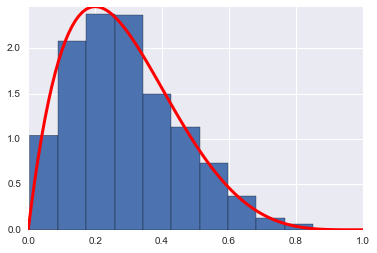

In [53]:
x = np.linspace(0, 1, 100)
y = func.pdf(x)
plt.ylim(0, y.max())
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3);
plt.hist(trace[:10000], normed=True);

In [ ]:
func = stats.expon() 
trace = metropolis(func=func)
plt.hist(trace, bins=50, normed=True);

x = np.linspace(0, 8, 100)
y = func.pdf(x)
plt.plot(x, y, 'r-', lw=3);

#### ¿Por qué funciona?

Se puede demostrar que un proceso de Markov, bajo ciertas condiciones, converje a una única distribución estacionaria. Una restricción suficiente, aunque no necesaria, que garantiza dicha convergencia es el _balance detallado_. El balance detallado significa implica que todas las transiciones deben ser reversibles, es decir

$$P(x_i)P(x_i\rightarrow x_{i+1}) = P(x_{i+1})P(x_{i+1}\rightarrow x_{i})$$

Intuitivamente se puede ver que si es posible moverse entre estados de forma proporcional a probabilidades relativas entre esos estados, y que si es posible acceder a todos los estados desde cualquier estado, entonces tarde o temprano la "caminata" debe ser capaz de muestrear la distribución de forma correcta.

### Monte Carlo Hamiltoniano.

Si la condición de balance detallado se cumple, existe una garantía teórica de que el método convergerá a una distribución estacionaria. Sin embargo, en la práctica y para cierto tipo de problemas la convergencia puede ser demasiado lenta. En esos casos se dice que se tiene un _mezclado lento_. Es por ello que varias modificaciones al algortimo de Metropolis-Hastings han sido propuesta (y seguramente otras serán propuestas en el futuro). Una de estas modificaciones se llama Monte Carlo Hamiltoniano, tambien conocido como Monte Carlo Híbrido (HMC). El método HMC tiene una interpretación física muy intuitiva; Supongamos que tenemos una pártícula que se mueve en una superficie (la distribución que queremos muestrear). Esta superficie en general será multidimensional (pero a los fines didácticos podemos imaginarlo como bi-dimensional). A fin de mover nuestra partícula vamos a usar variables auxiliares. A cada paso del procedimiento una nueva posición es propuesta dejando que la partícula evolucione según el Hamiltoniano, la posicion es luego aceptada o rechazada según Metropolis-Hastings.

Una de las ventajas de este método es que las nuevas posiciones propuestas tienen una alta chance de ser aceptadas, incluso para posiciones distantes respecto de la posición anterior. El Monte Carlo Hamiltoniano es mucho más cpu-demandante que Metropolis-Hastings; La razón es que es necesario computar el gradiente de la función potencial, al mismo tiempo los metodos HMC resultan en un mejor y más rápido mezclado. Para algunos problemas, especialmente para modelos complejos con mucho parámetros, esta situacion de compromiso termina favoreciendo al HMC. 

Un problema con los métodos HMC es que el método necesita de dos parámetros los cuales deben ajustarse empíricamente. Es por ello que se han propuesto métodos para ajustar los paráetros de forma automática. Uno de estos métodos, recientemente propuesto, es llamado _No-U-Turn Sampler_ (NUTS). Este método ha probado ser de mucha utilidad al ofrecer la eficiencia de muestreo del HMC, pero sin la necesidad de ajsutar manualmente ningún parámetro. 

## Further reading

* [The Handbook of Markov Chain Monte Carlo](http://www.mcmchandbook.net/HandbookTableofContents.html) Editors, Steve Brooks, Andrew Gelman, Galin L. Jones
and Xiao-Li Meng. 2011.

* [The Monte Carlo method](http://www.ncbi.nlm.nih.gov/pubmed/18139350) Metropolis, N & Ulam S. 1949.

* [Equations of State Calculations by Fast Computing Machines](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114) Metropolis _et. al._ 1953

* [Monte Carlo Sampling Methods Using Markov Chains and Their Applications](http://biomet.oxfordjournals.org/content/57/1/97) Hastings. 1970.